In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import warnings
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')
from scipy import stats
import scipy
from matplotlib_venn import venn3
from matplotlib_venn import venn2
import statistics

plt.rcParams['pdf.fonttype'] = 42
%matplotlib inline

sns.set('notebook')
sns.set(style='whitegrid')
sns.set_palette('deep')

# Load Data

In [2]:
folder = "./Tables/"

In [3]:
coverage_data = pd.read_csv(folder + "Table3__CoverageInformation.csv")
ptr_data = pd.read_excel(folder + "Table9__PTR_calculations.xlsx")
del ptr_data['coverage']
genome_data = pd.read_excel(folder + "Table5__GenomeData.xls")
seq_data = pd.read_excel(folder + "Table2__SequencingInformation.xlsx")
NICU_protospacers = pd.read_excel(folder + "Table4__CRISPR_information.xlsx",sheetname=1)
NCBI_protospacers = pd.read_excel(folder + "Table4__CRISPR_information.xlsx",sheetname=2)
Spacers = pd.read_excel(folder + "Table4__CRISPR_information.xlsx",sheetname=3)

### Merge datatables

In [4]:
db = pd.merge(coverage_data,genome_data)
db = pd.merge(db,ptr_data,on=["genome","sample"],how="outer")

##### Set  color dictionaries

In [5]:
g2color = {}
t2color = {}
colors = db[['genome','r','g','b','Taxonomic_name']]
genomes = set(db['genome'])
for genome in genomes:
    c = colors[colors['genome'] == genome]
    r, g, b = c['r'].values[0]/255.0, c['g'].values[0]/255.0, c['b'].values[0]/255.0
    g2color[genome] = (r,g,b)
    tax = c['Taxonomic_name'].values[0]
    t2color[tax] = (r,g,b)
g2color['Xinor Strains'] = (236/255.0,236/255.0,236/255.0)
g2color['Phage'] = (0/255.0,0/255.0,0/255.0)
g2color['Plasmid'] = (0/255.0,245/255.0,255/255.0)
t2color['Xinor Strains'] = (236/255.0,236/255.0,236/255.0)
t2color['Phage'] = (0/255.0,0/255.0,0/255.0)
t2color['Plasmid'] = (0/255.0,245/255.0,255/255.0)

bodyColors = {"Gut":(88/255.0,116/255.0,166/255.0),"Mouth":(93/255.0,159/255.0,98/255.0),"Skin":(183/255.0,92/255.0,94/255.0)}

# Community Composition

##### Bar Charts

In [6]:
# Ensure a spot for each DOL, abstract out phage / plasmid sequences
def stacked_bar(full_data, title, save = False):    
    sns.set_style("white")
    
    data = full_data[['DOL','Taxonomic_name','percent_project','sub_ID']]
    dat = data[data['sub_ID'] == "bacteria"]
    
    #Make empty placeholders for all DOLs in the range without at data, and abstract phage and plasmid
    for d in range(5,31,1):
        x = dat['percent_project'][(dat["DOL"] == d)]
        total = sum(x)
        if total == 0:
            dat = dat.append(pd.DataFrame([[d, "Xinor Strains",total]], columns =(['DOL','Taxonomic_name','percent_project'])))
            continue
        phage = sum(data['percent_project'][(data["DOL"] == d) & (data['sub_ID'] == 'phage')])
        plasmid = sum(data['percent_project'][(data["DOL"] == d) & (data['sub_ID'] == 'plasmid')])
        dat = dat.append(pd.DataFrame([[d, "Phage", phage]], columns =(['DOL','Taxonomic_name','percent_project'])))
        dat = dat.append(pd.DataFrame([[d, "Plasmid", plasmid]], columns =(['DOL','Taxonomic_name','percent_project'])))
            
    #Pivot data for plotting with native pandas methods
    dat = dat.pivot('DOL','Taxonomic_name','percent_project')
    colors = [t2color[i] for i in dat]
    p = dat.plot(kind='bar',stacked = True, color = colors)
    
    plt.legend(bbox_to_anchor = (1.52, 0.9))
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([0,100])

    plt.show()

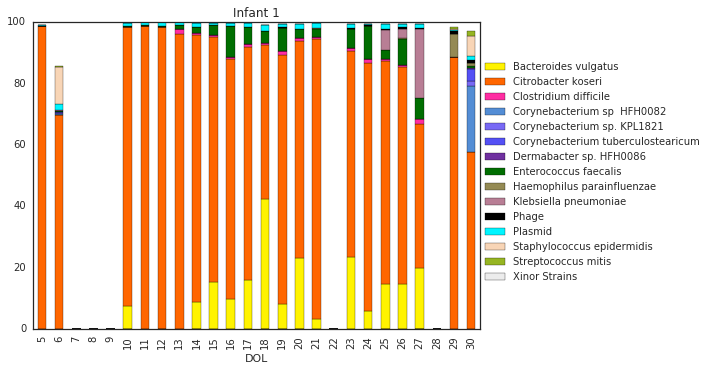

In [7]:
# This is to mash everything onto the same graph
temp = db.copy()
temp["DOL"][temp['sample'] == "0123Y"] = 29
temp["DOL"][temp['sample'] == "0106Y"] = 5
temp["DOL"][temp['sample'] == "0123W"] = 30

temp["DOL"][temp['sample'] == "0522W"] = 13
temp["DOL"][temp['sample'] == "0514Y"] = 29
temp["DOL"][temp['sample'] == "0528Y"] = 30

for inf in pd.Series.unique(db['Infant']):
    stacked_bar(temp[(temp['Infant'] == inf)],"Infant " + str(inf),save=True)

##### Report the community composition as text

In [8]:
for inf in pd.Series.unique(db['Infant']):
    temp = db[(db['Infant'] == inf)]
    samples = len(temp['sample'].unique())
    perc = temp['percent_project'].sum() / samples
    print("Infant {0} has {1} samples, with {2}% of reads accounted for".format(inf, samples,perc))
samples = len(db['sample'].unique())
perc = db['percent_project'].sum() / samples
print("Both infants have {0} samples, with {1}% of reads accounted for".format(samples,perc))

Infant 1 has 21 samples, with 98.72029486242859% of reads accounted for
Infant 5 has 24 samples, with 95.01802896829157% of reads accounted for
Both infants have 45 samples, with 96.74575305222243% of reads accounted for


# Comparing Body Sites

##### Venn diagram

In [9]:
def colored_ven_diagram(datum, title,verbose=False):
    datum = datum.sort("Taxonomic_name")
    print(datum['breadth'].sum() / len(datum['breadth']))
    names = {}
    sets = {}
    
    names[0] = "Skin"
    sets[0] = set(datum["Taxonomic_name"][datum["BodySite"] == "Skin"].unique().tolist())
    names[1] = "Mouth"
    sets[1] = set(datum["Taxonomic_name"][datum["BodySite"] == "Mouth"].unique().tolist())
    names[2] = "Gut"
    sets[2] = set(datum["Taxonomic_name"][datum["BodySite"] == "Gut"].unique().tolist())
    
    v = venn3([sets[0],sets[1],sets[2]], (names[0], names[1], names[2]))
    v = venn3([sets[0],sets[1],sets[2]], (names[0], names[1], names[2]))
    plt.title(title)

    if verbose:
        for i in [0,1,2]:
            print(names[i])
            for g in sorted(list(sets[i])):
                print(g)
    plt.plot()

In [10]:
for inf in db['Infant'].unique():
    colored_ven_diagram(db[(db['Infant'] == inf) & (db['percent_project'] >= 1) & (db['ID'] == 'bacteria') \
                           & (db['breadth'] >= 0.5)], "1% percent_project, 0.5 breadth, - Infant " + str(inf))
    plt.show()

0.9997059968095238


0.9888876394862387


##### Bar chart

The point of this plot is to look into the ability of each strain to colonize each body site

In [11]:
def col_potential_bar_plot(current_data, title):
    maxD = {}
    bD = {}
    gD = {}

    genome_names = pd.Series(current_data['Taxonomic_name']).unique()
    body_sites = pd.Series(current_data['BodySite']).unique()

    i = 0
    for g in genome_names:
        for b in body_sites:
            gD[i] = g
            bD[i] = b
            maxD[i] = pd.Series(current_data[current_data['BodySite'] == b][current_data['Taxonomic_name'] == g]['percent_project']).max()
            i+=1

    Gdata = pd.DataFrame({'genome' : gD,
                          'BodySite': bD,
                          'percent_project': maxD})  

    Gdata = Gdata.sort("genome")
    
    ax = sns.barplot(data = Gdata, x = 'genome', y = 'percent_project',hue = 'BodySite',palette = bodyColors)
    ax.set(ylim=(0, 100))
    ax.set(ylabel="Percent of Project")
    ax.set(xlabel="Microbial Strain")
    ax.set(title= title)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.show()

In [12]:
all_data = db
col_potential_bar_plot(all_data[(all_data['Infant'] == 1) & (all_data['ID'] == "bacteria")],\
                       "Infant 1- Highest abundance of each strain at each sampled body site")
col_potential_bar_plot(all_data[(all_data['Infant'] == 5) & (all_data['ID'] == "bacteria")],\
                       "Infant 5- Highest abundance of each strain at each sampled body site")

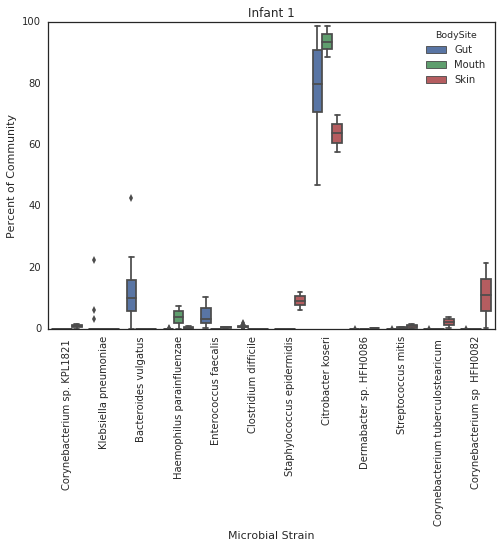

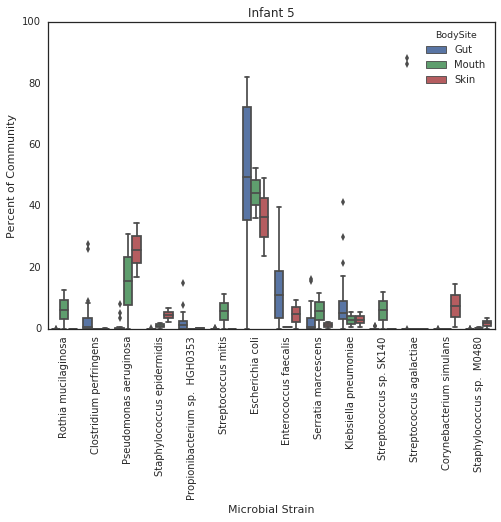

In [13]:
def col_potential_box_plot(df, title=None):
    df = df.sort('percent_project')
    df = df.sort('BodySite')
    p = sns.boxplot(data= df, x = 'Taxonomic_name', y = "percent_project",\
                    hue='BodySite',showfliers=True)
    p.set(ylim=(0, 100))
    p.set(ylabel="Percent of Community")
    p.set(xlabel="Microbial Strain")
    p.set(title= title)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.show()
    
for infant in all_data['Infant'].unique():
    df = all_data[(all_data['Infant'] == infant) & (all_data['ID'] == "bacteria")]
    col_potential_box_plot(df, title="Infant {0}".format(infant))

# PTR Data

##### Line plots of PTR over time

In [14]:
def comm_plot(datum,title,m,s,line):
    datum = datum.sort('Infant')
    datum = datum.sort('DOL')
    datum = datum[['DOL','Taxonomic_name','percent_project']]
    dat = datum.dropna()
    
    try:
        dat = dat.pivot('DOL','Taxonomic_name','percent_project')
        colors = [t2color[i] for i in dat]
        if len(colors) == 1:
            colors = colors[0]
            
        fig = dat.plot(kind='line', color = colors, marker=m, markersize = s,ls=line)
        plt.legend(bbox_to_anchor = (1.4, 0.5))
        plt.title(title)
        plt.xlabel('DOL')
        plt.ylabel('percent_project')
        plt.xticks(np.arange(4,30, 1.0))
        #plt.yticks(np.arange(1,2.6, 0.5))
        plt.ylim(0, 100)
        
        location = "/Users/mattolm/Box Sync/Banfield Lab/InfantSkinOral_Project/Figures/percent_project/"
        plt.savefig(location + str(title) + ".pdf",format="pdf",transparent=True)
        plt.show()
    except:
        pass
    
# Display all DOL numbers
def comm_plot2(datum,title,m,s,line):
    sns.set_style('white')
    datum = datum.sort('Infant')
    datum = datum.sort('DOL')
    datum = datum[['DOL','Taxonomic_name','PTR']]
    dat = datum.dropna()
    
    try:
        dat = dat.pivot('DOL','Taxonomic_name','PTR')
        colors = [t2color[i] for i in dat]
        if len(colors) == 1:
            colors = colors[0]
        
        #fig = plt.figure()
        #ax = fig.gca()
        #ax.set_xticks(numpy.arange(5,30,1))
        #sns.set_style("darkgrid")
        fig = dat.plot(kind='line', color = colors, marker=m, markersize = s,ls=line,figsize=(6,4))
        
        plt.legend(bbox_to_anchor = (1.6, 0.5))
        plt.title(title)
        plt.xlabel('DOL')
        plt.ylabel('PTR')
        plt.xticks(np.arange(4,30, 1.0))
        plt.yticks(np.arange(1,2.6, 0.5))
        plt.ylim(1, 2.5)
        
        location = "/Users/mattolm/Box Sync/Banfield Lab/InfantSkinOral_Project/Raw_figures/PTR/"
        plt.savefig(location + str(title) + ".pdf",format="pdf",transparent=True)
        plt.show()
        
    except:
        return
    
# Same as comm_plot3 but with abudance information
def comm_plot3(datum,title,m,s,line):
    datum = datum.sort('Infant')
    datum = datum.sort('DOL')
    datum = datum[['DOL','Taxonomic_name','percent_project']]
    dat = datum.dropna()
    
    try:
        dat = dat.pivot('DOL','Taxonomic_name','percent_project')
        colors = [t2color[i] for i in dat]
        if len(colors) == 1:
            colors = colors[0]
        
        
        
        fig = dat.plot(kind='line', color = colors, marker=m, markersize = s,ls=line,figsize=(6,4))
        
        #plt.figure(figsize=(15, 4))
        fig.figsize=(15,4)
        plt.legend(bbox_to_anchor = (1.6, 0.5))
        plt.title(title)
        plt.xlabel('DOL')
        plt.ylabel('Percent of Sample')
        plt.xticks(np.arange(4,30, 1.0))
        #plt.yticks(np.arange(1,2.6, 0.5))
        plt.ylim(0, 100)
        
        location = "/Users/mattolm/Box Sync/Banfield Lab/InfantSkinOral_Project/Raw_figures/PTR/"
        plt.savefig(location + str(title) + "_percentProject.pdf",format="pdf",transparent=True)
        plt.show()
        
    except:
        return
    
def top_genomes(datum, number):
    total = {}
    for g in datum['Taxonomic_name'].unique():
        sum = datum['percent_project'][datum['Taxonomic_name'] == g].sum()
        total[g] = sum
    
    i = 0
    top = []
    for genome in sorted(total, key = total.get, reverse = True):
        top.append(genome)
        i += 1
        if i == number:
            break
    return top

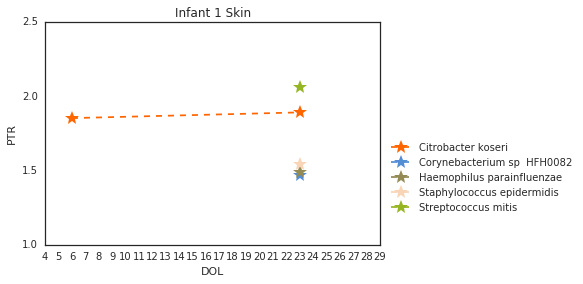

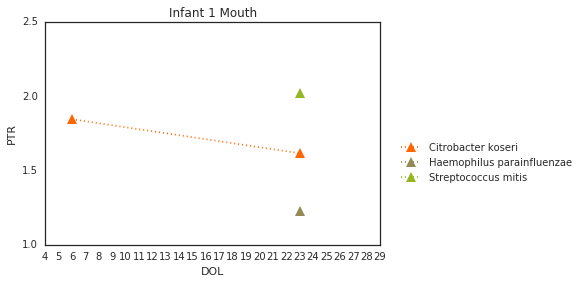

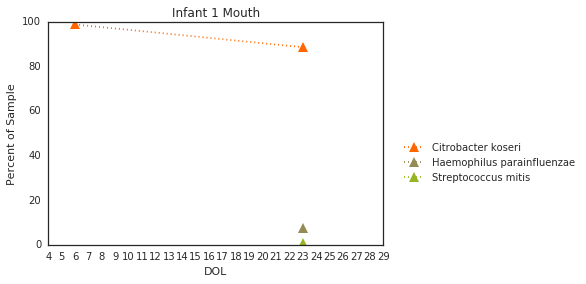

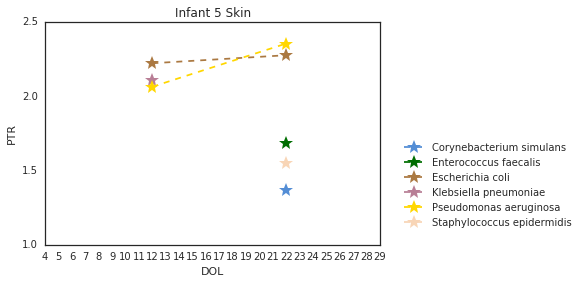

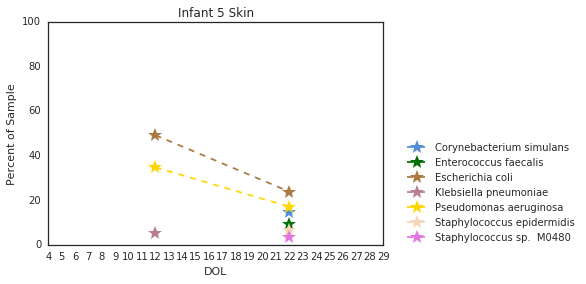

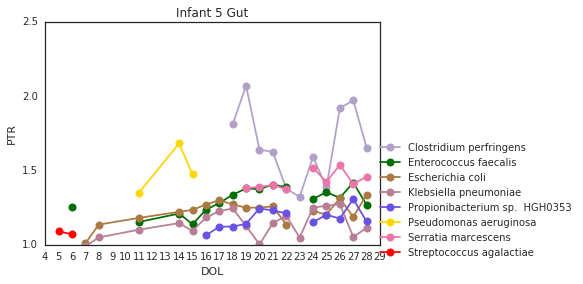

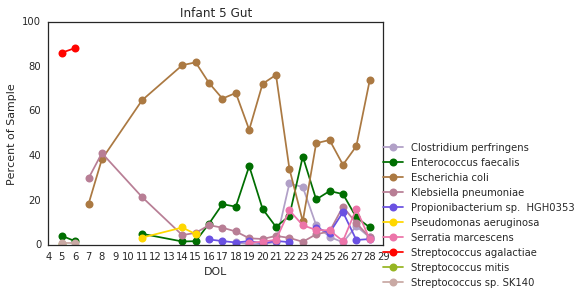

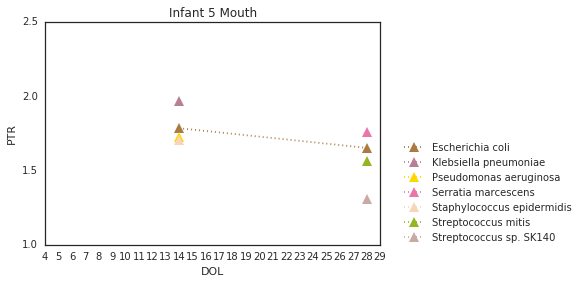

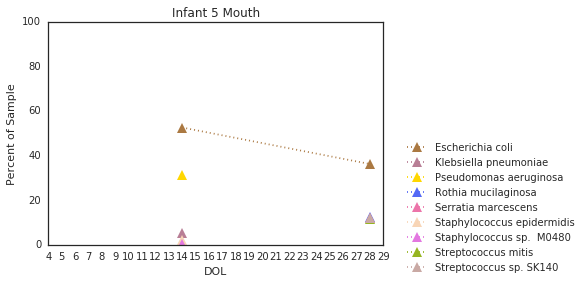

In [15]:
for inf in pd.Series.unique(db['Infant']):
    for bd in pd.Series.unique(db['BodySite']):
        # Draw bar charts based on % bacteria, phage, plasmid:
        if bd == "Gut":
            marker = 'o'
            s = 8
            line = "solid"
        elif bd == "Skin":
            marker = '*'
            s = 15
            line = "dashed"
        elif bd == "Mouth":
            marker = "^"
            s = 10
            line = "dotted"
        
        comm_plot2(db[(db['Infant'] == inf) & (db['BodySite'] == bd) & (db['coverage'] >= 5)],"Infant " + str(inf) + " " + str(bd),marker,s,line)
        comm_plot3(db[(db['Infant'] == inf) & (db['BodySite'] == bd) & (db['coverage'] >= 5) & (db['ID'] == 'bacteria')],"Infant " + str(inf) + " " + str(bd),marker,s,line)

##### Compare DOL vs. average growth rate statistics

In [16]:
# Based on the average PTR for each DOL
def DOL_vs_PTR(df):
    DOL = []
    PTR = []
    n = 0
    for d in sorted(df['DOL'].unique()):
        p = np.average(df['PTR'][df['DOL'] == d][df['BodySite'] == "Gut"].dropna().tolist())
        if not (p > 0):
            pass
        else:
            DOL.append(d)
            PTR.append(p)
            n += 1
    cor,p = stats.spearmanr(DOL,PTR)
    return(cor,p,n)

# Based on all PTR measurements seperately
def DOL_vs_PTR2(df):
    DOL = []
    PTR = []
    n = 0
    for d in sorted(df['DOL'].unique()):
        p = df['PTR'][df['DOL'] == d][df['BodySite'] == "Gut"].dropna().tolist()
        for value in p:
            DOL.append(d)
            PTR.append(value)
            n += 1
    cor,p = stats.spearmanr(DOL,PTR)
    return(cor,p,n)

r,p,n = DOL_vs_PTR2(db[(db['Infant'] == 1)])
print("Infant 1: R = {0}, p = {1}, n = {2}".format(r,p,n))
r,p,n = DOL_vs_PTR2(db[(db['Infant'] == 5)])
print("Infant 5: R = {0}, p = {1}, n = {2}".format(r,p,n))
r,p,n = DOL_vs_PTR2(db)
print("Both: R = {0}, p = {1}, n = {2}".format(r,p,n))

Infant 1: R = 0.27131368759857694, p = 0.06507873271822626, n = 47
Infant 5: R = 0.367939008188261, p = 0.00042062323119859517, n = 88
Both: R = 0.2973055429076798, p = 0.00046215731071921017, n = 135


##### Plot between body sites

In [17]:
def bd_compare_ptr_plot(current_data, title):
    sns.set_style('white')
    p = sns.swarmplot(data= current_data.sort('length',ascending=False), x = 'BodySite', y = "PTR")
    
    p.set(xlabel="PTR")
    p.set(ylabel="Body Site")
    p.set(title= title)
    plt.legend(bbox_to_anchor=(1.5, 0.9),bbox_transform=plt.gcf().transFigure)
    plt.show() 

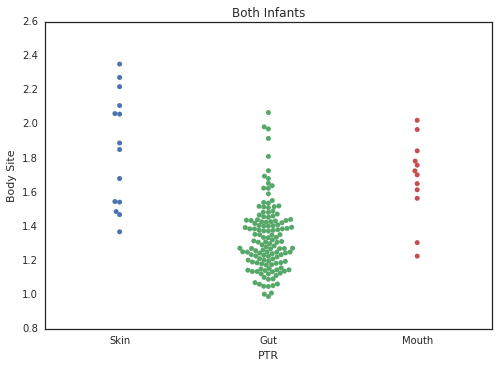

In [18]:
bd_compare_ptr_plot(db[(db['ID'] == "bacteria") & (db['coverage'] > 5)],"Both Infants")

##### Statistics between body sites

In [19]:
cat1 = all_data["PTR"][(all_data['BodySite'] == "Gut")].dropna().tolist()
cat2 = all_data["PTR"][(all_data['BodySite'] == "Mouth")].dropna().tolist()

print("Gut vs. Mouth: " + str(stats.mannwhitneyu(cat1, cat2)))

cat2 = all_data["PTR"][(all_data['BodySite'] == "Skin")].dropna().tolist()

print("Gut vs. Skin: " + str(stats.mannwhitneyu(cat1, cat2)))

cat1 = all_data["PTR"][(all_data['BodySite'] == "Mouth")].dropna().tolist()

print("Skin vs. Mouth: " + str(stats.mannwhitneyu(cat1, cat2)))

cat1 = all_data["PTR"][(all_data['Infant'] == 1)].dropna().tolist()
cat2 = all_data["PTR"][(all_data['Infant'] == 5)].dropna().tolist()

print("Infant 1 vs. 5: " + str(stats.mannwhitneyu(cat1, cat2))) 

Gut vs. Mouth: MannwhitneyuResult(statistic=226.0, pvalue=1.8294012540539419e-05)
Gut vs. Skin: MannwhitneyuResult(statistic=148.0, pvalue=1.0974231128354323e-07)
Skin vs. Mouth: MannwhitneyuResult(statistic=61.0, pvalue=0.1235799866059536)
Infant 1 vs. 5: MannwhitneyuResult(statistic=2049.0, pvalue=0.00061317406010995528)


### Show all PTR values for each species

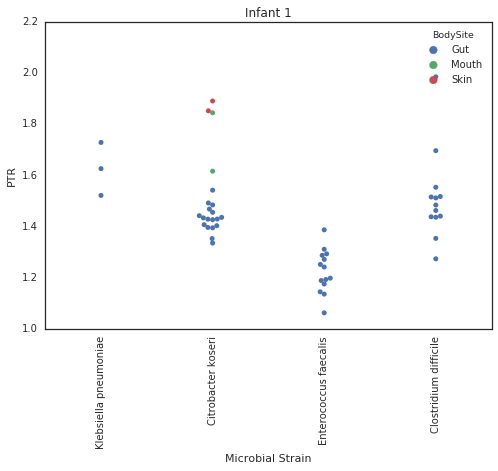

In [20]:
def species_ptr_plot(one, title):
    one = one.sort('BodySite')
    one = one[['DOL','Taxonomic_name','PTR','Infant','BodySite']]
    one = one.dropna()
    for n in pd.Series(one['Taxonomic_name']).unique():
        if len(one[one['Taxonomic_name'] == n]) < 3:
            one = one[one['Taxonomic_name'] != n]
    p = sns.swarmplot(data = one, x= 'Taxonomic_name' , y= 'PTR',hue = 'BodySite')
    p.set(ylabel="PTR")
    p.set(xlabel="Microbial Strain")
    p.set(title= title)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    #location = "/Users/mattolm/Box Sync/Banfield Lab/InfantSkinOral_Project/Figures/PTR/"
    #plt.savefig(location + "per_bacteria_" + str(title) + ".pdf",format="pdf",transparent=True)
    plt.show()
    
one = all_data[(all_data['Infant'] == 1) & (all_data['ID'] == "bacteria")]
species_ptr_plot(one, "Infant 1")
five = all_data[(all_data['Infant'] == 5) & (all_data['ID'] == "bacteria")]
species_ptr_plot(five, "Infant 5")
species_ptr_plot(all_data[(all_data['coverage'] > 5)], "Both")

# Phage / Plasmid Dynamics

##### Summary data with text

In [21]:
def average_percent(db):
    total = db['percent_project'].sum()
    return(total/len(db['sample'].unique()))

average_phage = average_percent(db[(db['sub_ID'] == "phage")])
average_plasmid = average_percent(db[(db['sub_ID'] == "plasmid")])
print("Total: {1:.2f}% phage, {2:.2f}% plasmid".format(inf,average_phage,average_plasmid))

for inf in db['Infant'].unique():
    average_phage = average_percent(db[(db['sub_ID'] == "phage") & (db['Infant'] == inf)])
    average_plasmid = average_percent(db[(db['sub_ID'] == "plasmid") & (db['Infant'] == inf)])
    print("Infant {0}: {1:.2f}% phage, {2:.2f}% plasmid".format(inf,average_phage,average_plasmid))
    
for bd in db['BodySite'].unique():
    average_phage = average_percent(db[(db['sub_ID'] == "phage") & (db['BodySite'] == bd)])
    average_plasmid = average_percent(db[(db['sub_ID'] == "plasmid") & (db['BodySite'] == bd)])
    print("BodySite {0}: {1:.2f}% phage, {2:.2f}% plasmid".format(bd,average_phage,average_plasmid))

Total: 2.08% phage, 0.83% plasmid
Infant 1: 0.20% phage, 1.16% plasmid
Infant 5: 3.72% phage, 0.55% plasmid
BodySite Skin: 0.90% phage, 1.09% plasmid
BodySite Gut: 2.36% phage, 0.86% plasmid
BodySite Mouth: 0.63% phage, 0.28% plasmid


##### Correlate phage with bacteria

In [22]:
def correlate_phage(datum):
    Table = {'phage':[], 'bacteria':[],'correlation':[],'p_value':[]}
    
    correction_factor = len(datum['genome'][datum['ID'] == "bacteria"].unique())
    for p in datum['genome'][datum['ID'] != "bacteria"].unique():
        for b in datum['genome'][datum['ID'] == "bacteria"].unique():
            
            df_clean = datum.pivot("sample","genome","percent_project")[[p,b]].dropna()
            cor,p_value = stats.pearsonr(df_clean[p],df_clean[b])
            if cor != cor:
                continue
            
            Table['phage'].append(p)
            Table['bacteria'].append(b)
            Table['correlation'].append(cor)
            Table['p_value'].append(p_value * correction_factor)
            
    df = pd.DataFrame(Table)
    
    return df
    
mobile_corr = correlate_phage(db)
mobile_corr[mobile_corr['p_value'] <= .05]

bacteria  correlation       p_value  \
0      0123W_Corynebacterium_sp__HFH0082_59_121     0.998646  1.909149e-24   
5                        0123W_Dermabacter_63_3     0.919577  9.911052e-08   
7               0123W_Streptococcus_mitis_40_11     0.912927  2.052952e-07   
9                   0123W_Corynebacterium_59_10     0.999181  1.613810e-26   
11                  0123W_Corynebacterium_58_17     0.999784  5.123478e-32   
36     0123W_Corynebacterium_sp__HFH0082_59_121     0.733275  4.046024e-03   
40       0123Y_Haemophilus_parainfluenzae_40_43     0.727238  4.875537e-03   
41                       0123W_Dermabacter_63_3     0.673126  2.145565e-02   
43              0123W_Streptococcus_mitis_40_11     0.945275  2.830730e-09   
45                  0123W_Corynebacterium_59_10     0.726327  5.012572e-03   
47                  0123W_Corynebacterium_58_17     0.728521  4.687912e-03   
48     0123W_Corynebacterium_sp__HFH0082_59_121     0.756844  1.859278e-03   
53                       0123W_Dermabacter_63_3     0.964531  4.960339e-11   
54       0123W_Staphylococcus_epidermidis_32_35     0.922006  7.477684e-08   
55              0123W_Streptococcus_mitis_40_11     0.673973  2.101190e-02   
57                  0123W_Corynebacterium_59_10     0.813976  1.858231e-04   
59                  0123W_Corynebacterium_58_17     0.802375  3.145101e-04   
60     0123W_Corynebacterium_sp__HFH0082_59_121     0.825107  1.083054e-04   
65                       0123W_Dermabacter_63_3     0.987338  3.049341e-15   
66       0123W_Staphylococcus_epidermidis_32_35     0.872991  6.310805e-06   
67              0123W_Streptococcus_mitis_40_11     0.739911  3.277338e-03   
69                  0123W_Corynebacterium_59_10     0.873763  5.974322e-06   
71                  0123W_Corynebacterium_58_17     0.864013  1.164132e-05   
77                       0123W_Dermabacter_63_3     0.875013  5.463029e-06   
78       0123W_Staphylococcus_epidermidis_32_35     0.987823  2.107636e-15   
81                  0123W_Corynebacterium_59_10     0.651528  3.577877e-02   
83                  0123W_Corynebacterium_58_17     0.636457  4.998271e-02   
118  0118A1023_Bacteroides_vulgatus-like_42_520     0.972437  4.660024e-12   
120    0123W_Corynebacterium_sp__HFH0082_59_121     0.739708  3.298835e-03   
124      0123Y_Haemophilus_parainfluenzae_40_43     0.720660  5.942070e-03   
..                                          ...          ...           ...   
244                0528Y_Escherichia_coli_51_14     0.993935  3.555426e-21   
264                  0522W_Corynebacterium_59_9     0.662623  1.088182e-02   
270         0514Y_Staphylococcus_sp__M0480_31_3     0.649280  1.552191e-02   
290       0514Y_Staphylococcus_epidermidis_32_9     0.976223  1.102256e-14   
292                  0522W_Corynebacterium_59_9     0.981202  8.506860e-16   
298         0514Y_Staphylococcus_sp__M0480_31_3     0.987540  9.508226e-18   
300                0528Y_Escherichia_coli_51_14     0.985763  4.085817e-17   
317       0525A0216_Klebsiella_pneumoniae_57_51     0.976210  1.108828e-14   
336    0522A0213_Clostridium_perfringens_28_397     0.626704  2.728856e-02   
350    0522A0213_Clostridium_perfringens_28_397     0.687417  5.360603e-03   
359       0525A0216_Klebsiella_pneumoniae_57_51     0.678415  6.985093e-03   
374       0514Y_Staphylococcus_epidermidis_32_9     0.905474  3.098233e-08   
376                  0522W_Corynebacterium_59_9     0.997227  6.579077e-25   
382         0514Y_Staphylococcus_sp__M0480_31_3     0.985022  7.116329e-17   
388       0514Y_Staphylococcus_epidermidis_32_9     0.810147  4.174419e-05   
389      0511A0202_Pseudomonas_aeruginosa_66_19     0.638289  2.054171e-02   
390                  0522W_Corynebacterium_59_9     0.689330  5.061473e-03   
396         0514Y_Staphylococcus_sp__M0480_31_3     0.794517  9.216898e-05   
402       0514Y_Staphylococcus_epidermidis_32_9     0.676254  7.433448e-03   
403      0511A0202_Pseudomonas_aeruginosa_66_19     0.917080 

##### Look at host dynamics

In [23]:
def com_profile(cur_data,title):
    cur_data = cur_data.sort('Infant')
    cur_data = cur_data.sort('DOL')
    g = sns.FacetGrid(data = cur_data, hue = 'Taxonomic_name',aspect=2, size = 3)
    g = g.map(plt.plot, "DOL", 'scaled',marker="o").add_legend().set_titles("{col_name} {row_name}").set_axis_labels("Day of Life", "% of sample reads")
    plt.show()
    
def com_profile2(cur_data,title):
    cur_data = cur_data.sort('Infant')
    cur_data = cur_data.sort('DOL')
    if len(pd.Series.unique(cur_data['Taxonomic_name'])) == 1:
        return
    if len(pd.Series.unique(cur_data['DOL'])) == 1:
        return
    g = sns.FacetGrid(data = cur_data, col = 'BodySite', hue = 'Taxonomic_name', palette = t2color, aspect=2, size = 3)
    g = g.map(plt.plot, "DOL", 'scaled',marker="o").add_legend().set_titles("{col_name} " + str(title)).set_axis_labels("Day of Life", "% of sample reads")
    plt.plot()
    plt.show()

# normalize data on bodysite and genome
def norm_BG(data):
    genome_names = pd.Series.unique(data['genome'])
    bodySites = pd.Series.unique(data['BodySite'])
    data['scaled'] = 2
    for g in genome_names:
        for b in bodySites:
            x = data['percent_project'][(data['genome'] == g) & (data['BodySite'] == b)].values.astype(float)
            max_abs_scaler = preprocessing.MaxAbsScaler()
            x_scaled = max_abs_scaler.fit_transform(x)
            norm_data = pd.Series(x_scaled)
            data['scaled'][(data['genome'] == g) & (data['BodySite'] == b)] = norm_data
            #com_profile(all_data[all_data["Host"] == g],10)
    return data

# normalize data genome only
def norm_G(data):
    data['scaled'] = 2
    genome_names = pd.Series.unique(data['genome'])
    for g in genome_names:
        x = data['percent_project'][(data['genome'] == g)].values.astype(float)
        max_abs_scaler = preprocessing.MaxAbsScaler()
        x_scaled = max_abs_scaler.fit_transform(x)
        norm_data = x_scaled
        data['scaled'][(data['genome'] == g)] = norm_data
        #com_profile(all_data[all_data["Host"] == g],10)
    return data

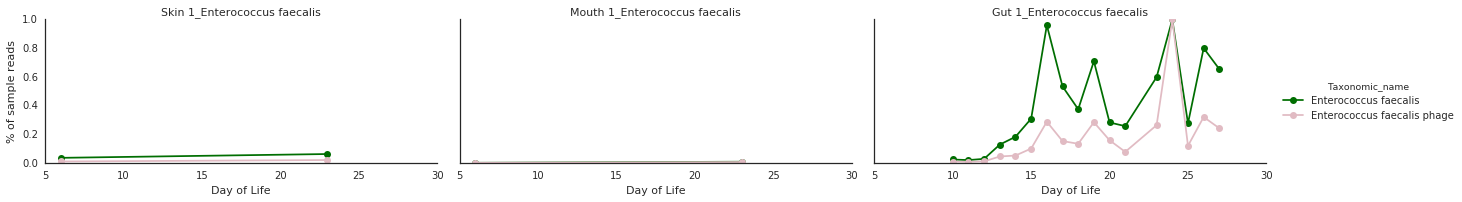

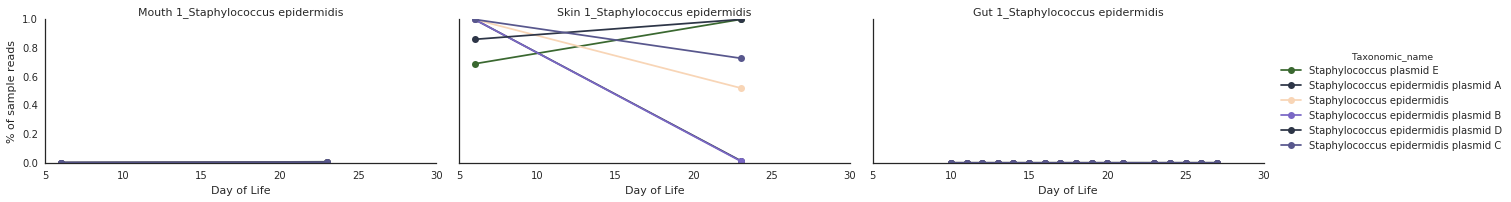

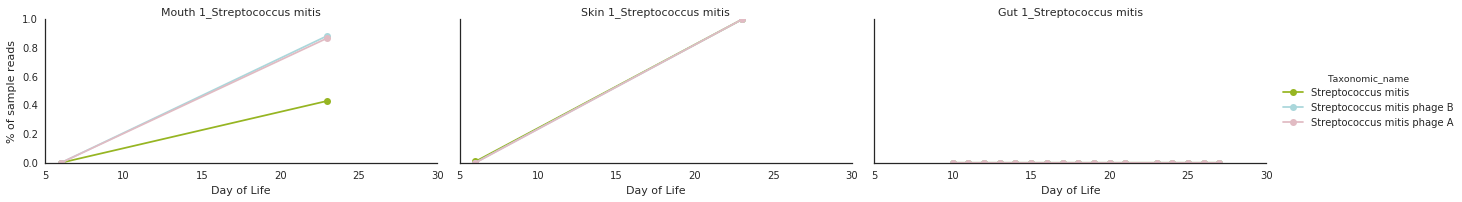

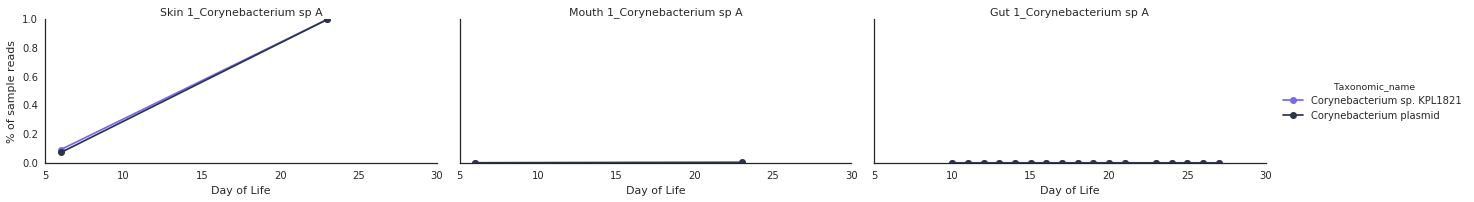

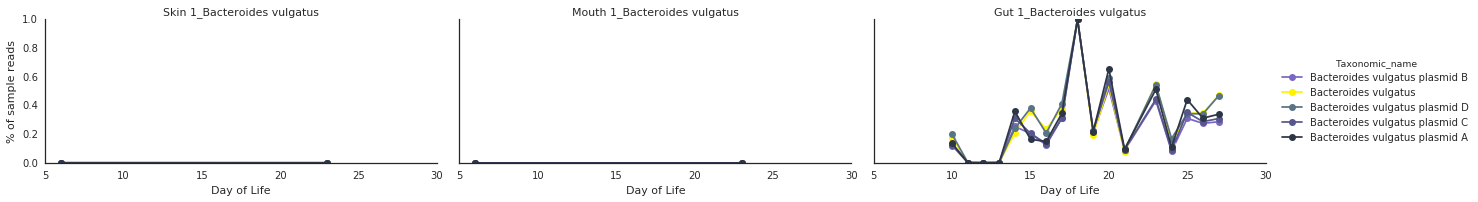

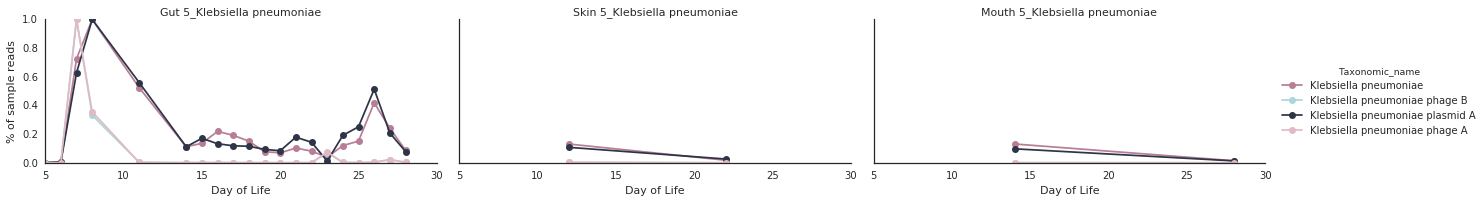

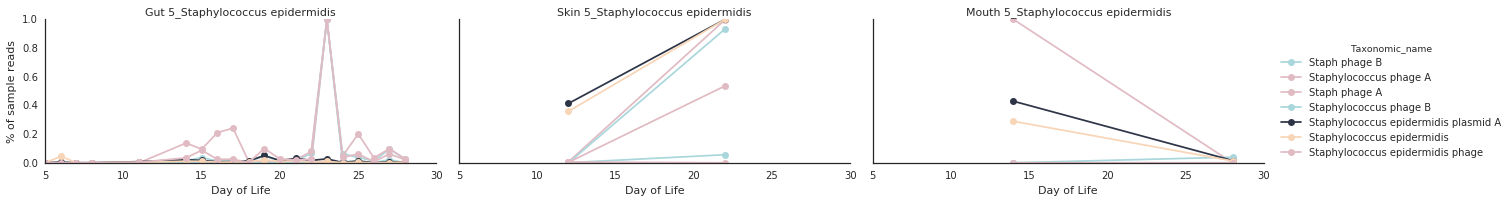

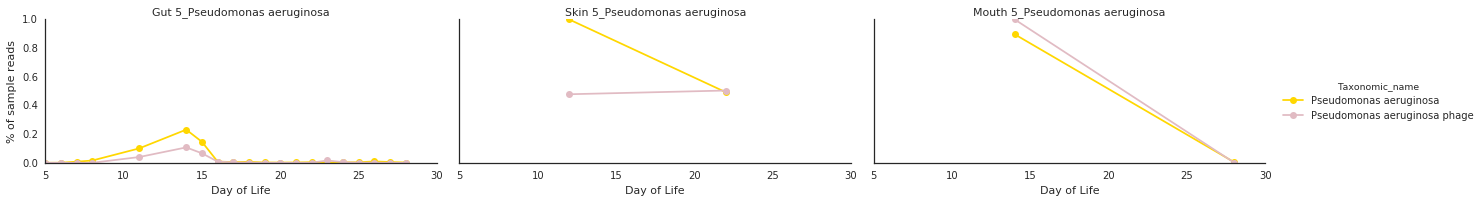

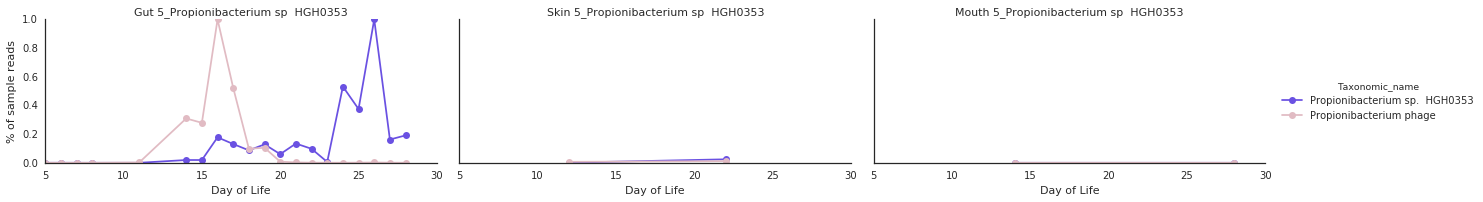

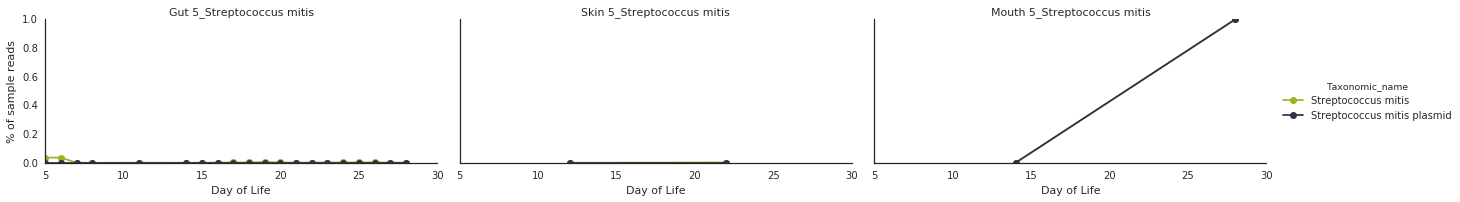

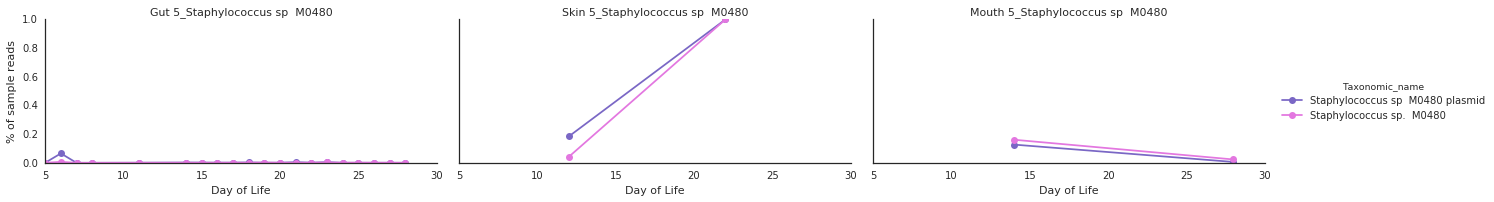

In [24]:
subset = norm_G(db)

# Make plots
genome_names = pd.Series.unique(db['genome'])
bodySites = pd.Series.unique(db['BodySite'])
hosts = pd.Series.unique(db['Host'])
one = subset[(subset['Infant'] == 1)]
hosts = pd.Series.unique(one['Host'])
for h in hosts:
    pass
    #com_profile(one[(one['Host'] == h) & (one['BodySite'] == "Gut")],str(1) + "_" + h)
    com_profile2(one[(one['Host'] == h)],str(1) + "_" + h)
    
five = subset[(subset['Infant'] == 5)]
hosts = pd.Series.unique(five['Host'])
for h in hosts:
    pass
    #com_profile(five[(five['Host'] == h)],str(5) + "_" + h)
    com_profile2(five[(five['Host'] == h)],str(5) + "_" + h)

# CRISPR analysis

### Summary Information

In [25]:
def spacer_summary(sp,verbose=False):
    org_spacers = {}
    org_arrays = {}
    for inf in pd.Series.unique(sp['spacer_infant']).tolist():
        sub = sp[sp['spacer_infant'] == inf]
        if verbose: print("Infant " + inf + " - " + str(len(sub)) + " spacers")
        for org in pd.Series.unique(sub['spacer_bin']).tolist():
            subO = sub[sub['spacer_bin'] == org]
            if verbose: print(str(org) + " " + str(len(subO)) + " spacers over " + str(len(subO['repeat_sequence'].unique())) + " repeats")
            org_spacers[str(org)] = str(len(subO))
            org_arrays[str(org)] = str(len(subO['repeat_sequence'].unique()))
        if verbose: print()
    return(org_spacers,org_arrays)

def protospacer_summary(cr, verbose=False):
    dic = {}
    inf_dic = {}
    scaff_dic = {}
    for infantS in pd.Series.unique(cr['spacer_infant']):
        infs = 0
        hits = 0
        self = 0
        for infantP in pd.Series.unique(cr['protospacer_infant']):
            s = cr[(cr['spacer_infant'] == infantS) & (cr['protospacer_infant'] == infantP)]
            bb = pd.Series.unique(s['spacer_sequence'])
            if verbose: print(str(len(bb)) + " spacers from infant " + str(infantS) + " hit infant " + str(infantP))
            infs += 1
            hits += len(bb)
            if infantP == infantS:
                self = len(bb)
            
            for spacer in bb:
                if spacer in dic:
                    dic[spacer] += 1
                    inf_dic[spacer].append(infantP)
                else:
                    dic[spacer] = 1
                    inf_dic[spacer] = [infantP]
            
        if verbose: print("\n*** Average of " + str(hits/infs) + " spacers from infant " + str(infantS) + " hit another infant ***")
        if verbose: print("*** " + str(self) + " spacers from infant " + str(infantS) + " hit itself ***\n")
    
    for spacer in sorted(dic, key = dic.get, reverse = True):
        if verbose: print(str(spacer) + " - " + str(dic[spacer]))
        if verbose: print(str(cr["spacer_bin"][cr["spacer_sequence"] == spacer].unique()[0]) + ", " + str(cr["spacer_scaffold"][cr["spacer_sequence"] == spacer].unique()[0]))
        if verbose: print(inf_dic[spacer])
    return(dic,inf_dic)

def find_spacers(cr):
    org_effective_spacers = {}
    org_super_spacers = {}
    super_spacer = []
    for org in cr['spacer_bin'].unique():
        df = cr[cr['spacer_bin'] == org]
        org_effective_spacers[org] = len(df['spacer_sequence'].unique())
        for sp in df['spacer_sequence'].unique():
            if len(df['protospacer_infant'][df['spacer_sequence'] == sp].unique()) > 1:
                super_spacer.append(sp)
                if org in org_super_spacers: 
                    org_super_spacers[org] += 1
                else: org_super_spacers[org] = 1
    return org_effective_spacers, org_super_spacers, super_spacer

def generate_organism_summary(proto_db,spacer_db):
    spacer_DIC,infant_dic = protospacer_summary(proto_db,False)
    org_spacers, org_arrays = spacer_summary(spacer_db)
    org_effective_spacers, org_super_spacers, super_spacer = find_spacers(proto_db)

    organism_summary = pd.DataFrame({'spacers' : pd.Series(org_spacers),
                      'repeat_types': pd.Series(org_arrays),
                      'effective_spacers' : pd.Series(org_effective_spacers),
                      'super_spacers' : pd.Series(org_super_spacers)})

    organism_summary = organism_summary.fillna(value=0)
    organism_summary['organism'] = organism_summary.index
    organism_summary[["repeat_types","effective_spacers","spacers","super_spacers"]] = organism_summary[["repeat_types","effective_spacers","spacers","super_spacers"]].astype(int)
    organism_summary.reset_index(level=0, inplace=True)
    del organism_summary['index']
    organism_summary.sort('spacers',ascending = False)
    organism_summary.sort('super_spacers',ascending = False)
    organism_summary.sort('super_spacers',ascending = False)
    
    return(organism_summary)

def generate_spacer_summary(proto_db,spacer_db):
    spacer_dic = {}
    org_dic = {}
    targeted_infants = {}
    targeted_scaffolds = {}
    spacer_DIC,infant_dic = protospacer_summary(proto_db,False)

    i = 0
    for spacer in spacer_DIC:
        df = proto_db[proto_db['spacer_sequence'] == spacer]
        proto_scaffolds = []

        for inf in df['protospacer_infant'].unique():
            hit_scaffolds = df['protospacer_scaffold'][df['protospacer_infant'] == inf].tolist()
            proto_scaffolds.append(hit_scaffolds[0])

        spacer_dic[i] = spacer
        org_dic[i] = df["spacer_bin"].unique()[0]
        targeted_infants[i] = df['protospacer_infant'].unique()
        targeted_scaffolds[i] = proto_scaffolds
        i += 1

    effective_spacers = pd.DataFrame({'spacer' : pd.Series(spacer_dic),
                          'organism': pd.Series(org_dic),
                          'targeted_infants' : pd.Series(targeted_infants),
                          'targetd_scaffolds' : pd.Series(targeted_scaffolds)})
    #effective_spacers.to_csv("/Users/mattolm/Box Sync/Banfield Lab/InfantSkinOral_Project/Raw_Data/CRISPR/Tables/EffectiveSpacers.csv")
    return(effective_spacers)

def generate_superspacer_summary(proto_db,spacer_db):
    spacer_dic = {}
    org_dic = {}
    targeted_infants = {}
    targeted_scaffolds = {}
    org_effective_spacers, org_super_spacers, super_spacer = find_spacers(proto_db)

    i = 0
    for spacer in super_spacer:
        df = proto_db[proto_db['spacer_sequence'] == spacer]
        proto_scaffolds = []

        for inf in df['protospacer_infant'].unique():
            hit_scaffolds = df['protospacer_scaffold'][df['protospacer_infant'] == inf].tolist()
            proto_scaffolds.append(hit_scaffolds[0])

        spacer_dic[i] = spacer
        org_dic[i] = df["spacer_bin"].unique()[0]
        targeted_infants[i] = df['protospacer_infant'].unique()
        targeted_scaffolds[i] = proto_scaffolds
        i += 1

    super_spacers = pd.DataFrame({'spacer' : pd.Series(spacer_dic),
                          'organism': pd.Series(org_dic),
                          'targeted_infants' : pd.Series(targeted_infants),
                          'targetd_scaffolds' : pd.Series(targeted_scaffolds)})
    return(super_spacers)

In [26]:
CRISPR_db = generate_organism_summary(NICU_protospacers,Spacers)
CRISPR_db['Infant'] = CRISPR_db['organism'].str[0:2].astype(int)
for inf in list(CRISPR_db['Infant'].unique()):
    C_orgs = len(CRISPR_db['organism'][CRISPR_db['Infant'] == inf].unique())
    T_orgs = len(db['genome'][(db['Infant'] == inf) & (db['ID'] == 'bacteria')].unique())
    T_spacers = CRISPR_db['spacers'][CRISPR_db['Infant'] == inf].sum()
    print("Infant {0}: {1} percent of organisms have CRISPR, with a total of {2} spacers".format(inf,C_orgs/T_orgs,T_spacers))

Infant 1: 0.5 percent of organisms have CRISPR, with a total of 111 spacers
Infant 5: 0.42857142857142855 percent of organisms have CRISPR, with a total of 182 spacers


# Generate Tables

##### For each project, the percent of project needed for X coverage

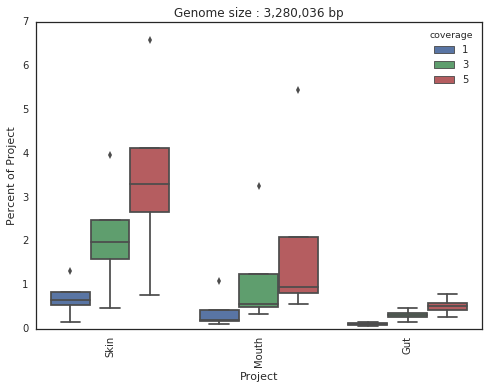

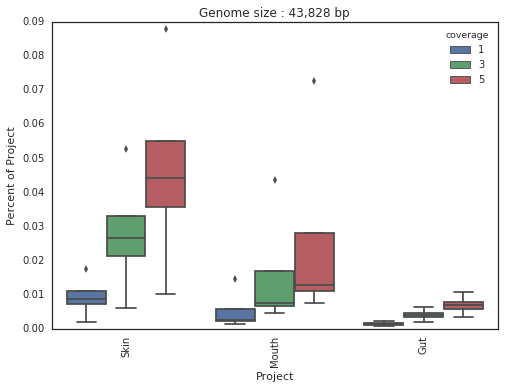

In [27]:
def gen_table(df,gen_sizes = [10000,100000,1000000,10000000],covs = [1,5,10]): 
    samples = {}
    per_projs = {}
    coverages = {}
    genome_sizes = {}
    i = 0
    for sample in df['Sample'].unique():
        for size in gen_sizes:
            for cov in covs:
                size = int(size)
                samples[i] = sample
                genome_sizes[i] = size
                coverages[i] = cov
                bases = int(df['HR_bases'][df['Sample'] == sample])
                per_projs[i] = ((cov * size) / bases) * 100
                i+=1
                
    new_table = pd.DataFrame({'project' : pd.Series(samples),
                             'percent_project' : pd.Series(per_projs),
                             'genome_size' : pd.Series(genome_sizes),
                             'coverage' : pd.Series(coverages)})

    new_table['Bd'] = new_table['project'].str[4].map({"A":"Gut","W":"Skin","Y":"Mouth"})
    return new_table

def plot_cov_req(df,titl):
    i = 0
    for size in df['genome_size'].unique():
        title = titl[i]
        i += 1
        d = df[df['genome_size'] == size]
        ax = sns.boxplot(data = d, x = 'Bd', y = 'percent_project',hue = 'coverage')
        #ax.set(ylim=(0, 20))
        ax.set(ylabel="Percent of Project")
        ax.set(xlabel="Project")
        ax.set(title= "Genome size : {:,} bp".format(size))
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=90)
        plt.show()
        
avg_bac_genome = db['length'][db['ID'] == "bacteria"].sum() / len(db['length'][db['ID'] == "bacteria"])
avg_mobile_genome = db['length'][db['ID'] != "bacteria"].sum() / len(db['length'][db['ID'] == "bacteria"])
covReq_df = gen_table(seq_data, gen_sizes = [avg_bac_genome,avg_mobile_genome], covs = [1,3,5])
plot_cov_req(covReq_df,['bacteria','mobile'])

##### Total coverage per genome per bodySite

In [28]:
def gen_total_cov_table(df):
    i = 0
    genome_d = {}
    bodySite_d = {}
    total_cov_d = {}
    for genome in df['genome'].unique():
        for bd in df['BodySite'].unique():
            coverage = float(df['coverage'][(df['genome'] == genome) & (df['BodySite'] == bd)].sum())
            genome_d[i] = genome
            bodySite_d[i] = bd
            total_cov_d[i] = coverage
            i+=1
            
    new_table = pd.DataFrame({'genome' : pd.Series(genome_d),
                             'BodySite' : pd.Series(bodySite_d),
                             'total_coverage' : pd.Series(total_cov_d)})
    return new_table

def find_candidates(df,metric = 'total_coverage'):
    print("genome\tlocations\tmin coverage amoung locations")
    for genome in df['genome'].unique():
        d = df[df['genome'] == genome]
        if len(d['BodySite'].unique()) > 1:
            print("{0}\t{1}\t{2}".format(genome,list(d['BodySite'].unique()),int(d[metric].min())))

tCov_df = gen_total_cov_table(db[db['ID'] == 'bacteria']).sort('total_coverage',ascending=False)
find_candidates(db[db['coverage'] >= 10],'coverage')
tCov_df[tCov_df['total_coverage'] >= 10]

genome	locations	min coverage amoung locations
0123A_Citrobacter_koseri_6	['Skin', 'Mouth', 'Gut']	73
0123Y_Haemophilus_parainfluenzae_40_43	['Skin', 'Mouth']	10
0528Y_Escherichia_coli_51_14	['Gut', 'Skin', 'Mouth']	12
0525A0216_Klebsiella_pneumoniae_57_51	['Gut', 'Mouth']	14
0511A0202_Pseudomonas_aeruginosa_66_19	['Gut', 'Skin', 'Mouth']	16
0528Y_Streptococcus_39_12	['Mouth', 'Gut']	12
0123W_Streptococcus_phage	['Mouth', 'Skin']	49
qb307082014_C_scaffold_27	['Gut', 'Mouth', 'Skin']	460
0123Y_scaffold_28	['Mouth', 'Skin']	381
0522W_scaffold_284	['Gut', 'Skin', 'Mouth']	10
0524A0215_Escherichia_coli_phage_53_287	['Gut', 'Mouth', 'Skin']	17
0522W_Staphylococcus_phage	['Gut', 'Skin']	13
0522W_scaffold_51	['Gut', 'Skin']	12
0522W_scaffold_592	['Skin', 'Gut', 'Mouth']	16
0512W_scaffold_340	['Gut', 'Mouth', 'Skin']	19
0514Y_scaffold_250	['Gut', 'Mouth', 'Skin']	18
0505A0127_Klebsiella_pneumoniae_phage	['Gut', 'Skin']	10
0522W_scaffold_887	['Gut', 'Skin']	14
0514Y_Staphylococcus_phage_34_154	

BodySite                                         genome  total_coverage
4       Gut                     0123A_Citrobacter_koseri_6     9087.438063
28      Gut                   0528Y_Escherichia_coli_51_14     6881.991978
34      Gut         0519A0210_Enterococcus_faecalis_37_406     3588.422059
31      Gut      0506A0128_Streptococcus_agalactiae_35_952     2171.548963
67      Gut     0118A1023_Bacteroides_vulgatus-like_42_520     1236.008952
37      Gut          0525A0216_Klebsiella_pneumoniae_57_51     1147.765208
52      Gut       0522A0213_Clostridium_perfringens_28_397     1085.622152
5     Mouth                     0123A_Citrobacter_koseri_6      930.073584
49      Gut  0520A0211_Propionibacterium_sp__HGH0353_63_15      794.376275
7       Gut          0113A1018_Enterococcus_faecalis_36_17      772.354943
55      Gut           0527A0218_Serratia_marcescens_60_106      502.020480
3      Skin                     0123A_Citrobacter_koseri_6      332.697029
29    Mouth                   0528Y_Escherichia_coli_51_14      213.580407
0      Skin       0123W_Corynebacterium_sp__HFH0082_59_121      191.256033
25      Gut                0125A1030_Klebsiella_pneu_56_47      158.079669
10      Gut          0119A1024_Clostridium_difficile_29_11      106.389132
43      Gut         0511A0202_Pseudomonas_aeruginosa_66_19       99.720107
44    Mouth         0511A0202_Pseudomonas_aeruginosa_66_19       81.879597
18     Skin         0123W_Staphylococcus_epidermidis_32_35       81.445503
14    Mouth         0123Y_Haemophilus_parainfluenzae_40_43       67.850826
27     Skin                   0528Y_Escherichia_coli_51_14       61.449013
61      Gut                      0528Y_Streptococcus_39_12       41.453632
42     Skin         0511A0202_Pseudomonas_aeruginosa_66_19       31.439298
69     Skin                    0123W_Corynebacterium_58_17       27.243044
62    Mouth                      0528Y_Streptococcus_39_12       19.457106
21     Skin                0123W_Streptococcus_mitis_40_11       18.648087
38    Mouth          0525A0216_Klebsiella_pneumoniae_57_51       18.611890
59    Mouth                0528Y_Streptococcus_mitis_40_11       17.859224
58      Gut                0528Y_Streptococcus_mitis_40_11       17.845874
63     Skin                    0123W_Corynebacterium_59_10       17.379526
77    Mouth                0528Y_Rothia_mucilaginosa_59_11       16.574342
45     Skin                     0522W_Corynebacterium_59_9       15.243857
41    Mouth          0514Y_Staphylococcus_epidermidis_32_9       14.583984
40      Gut          0514Y_Staphylococcus_epidermidis_32_9       13.785966
39     Skin          0514Y_Staphylococcus_epidermidis_32_9       11.883254
12     Skin         0123Y_Haemophilus_parainfluenzae_40_43       10.335667